# 성능 최적화 종합실습 : Car seat sales
유아용 카시트 매출액을 예측해 봅시다.

* 카시트에 대해서 지역 매장 별 매출액을 예측하고자 합니다.

![](https://cdn.images.express.co.uk/img/dynamic/24/590x/child-car-seat-986556.jpg?r=1532946857754)

## 1.환경준비

### (1) Import

In [1]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import * 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings(action='ignore')

### (2) 함수 생성

* 선형회귀용 전진선택법

In [2]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def forward_stepwise_linear(x_train, y_train):

    # 변수목록, 선택된 변수 목록, 단계별 모델과 AIC 저장소 정의
    features = list(x_train)
    selected = []
    step_df = pd.DataFrame({ 'step':[], 'feature':[],'aic':[]})

    # 
    for s in range(0, len(features)) :
        result =  { 'step':[], 'feature':[],'aic':[]}

        # 변수 목록에서 변수 한개씩 뽑아서 모델에 추가
        for f in features :
            vars = selected + [f]
            x_tr = x_train[vars]
            model = OLS(y_train, add_constant(x_tr)).fit()
            result['step'].append(s+1)
            result['feature'].append(vars)
            result['aic'].append(model.aic)
        
        # 모델별 aic 집계
        temp = pd.DataFrame(result).sort_values('aic').reset_index(drop = True)

        # 만약 이전 aic보다 새로운 aic 가 크다면 멈추기
        if step_df['aic'].min() < temp['aic'].min() :
            break
        step_df = pd.concat([step_df, temp], axis = 0).reset_index(drop = True)

        # 선택된 변수 제거
        v = temp.loc[0,'feature'][s]
        features.remove(v)

        selected.append(v)
    
    # 선택된 변수와 step_df 결과 반환
    return selected, step_df

* 변수 중요도 그래프

In [3]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

### (3) Data Loading

In [4]:
data_path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(data_path)

**변수설명**
> * Sales - 각 지역 판매량(단위 : 1000개) <== Target
* CompPrice - 각 지역 경쟁사 가격
* Income - 각 지역 평균 소득수준(단위 : 1000달러)
* Advertising - 각 지역, 회사의 광고 예산(단위 : 1000달러)
* Population - 지역 인구수(단위 : 1000명)
* Price - 자사 지역별 판매가격
* ShelveLoc - 진열상태
* Age - 지역 인구의 평균 연령
* Education - 각 지역 교육수준 레벨
* Urban - 매장 도시 지역 여부
* US - 매장이 미국에 있는지 여부

## 2.데이터 이해

* 둘러보기

In [5]:
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## 3.데이터 준비

### (1) 데이터 정리

In [6]:
data['Diff_Price'] = data['CompPrice'] - data['Price']
data.drop('CompPrice', axis = 1, inplace = True)

### (2) 데이터분할1 : x, y 나누기

In [17]:
target = 'Sales'
x = data.drop(target, axis=1)
y = data.loc[:, target]

### (3) NA 조치

### (4) 가변수화

In [18]:
columns = ['ShelveLoc', 'Education', 'Urban', 'US']
x = pd.get_dummies(x, columns=columns, drop_first=True)
x.rename(columns={'Urban_Yes' : 'Urban', 'US_Yes' : 'US'}, inplace=True)
x.head()

,Income,Advertising,Population,Price,Age,Diff_Price,ShelveLoc_Good,ShelveLoc_Medium,Education_11,Education_12,Education_13,Education_14,Education_15,Education_16,Education_17,Education_18,Urban,US
0,73,11,276,120,42,18,0,0,0,0,0,0,0,0,1,0,1,1
1,48,16,260,83,65,28,1,0,0,0,0,0,0,0,0,0,1,1
2,35,10,269,80,59,33,0,1,0,1,0,0,0,0,0,0,1,1
3,100,4,466,97,55,20,0,1,0,0,0,1,0,0,0,0,1,1
4,64,3,340,128,38,13,0,0,0,0,1,0,0,0,0,0,1,0


### (5) 데이터분할2 : train : validation 나누기

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.3)

### (6) Scaling
KNN 알고리즘을 적용하기 위해서는 스케일링을 해야 합니다.

In [21]:
Scaler = MinMaxScaler()
x_train_s = Scaler.fit_transform(x_train)
x_val_s = Scaler.transform(x_val)

In [128]:
# 개인적으로 만든 함수.
def printPerform(y_val, pred):
    print("R2 Score : ", r2_score(y_val, pred))
    print('RMSE : ', mean_squared_error(y_val, pred, squared=False))
    print('MAE : ', mean_absolute_error(y_val, pred))
    print('MAPE : ', mean_absolute_percentage_error(y_val, pred))
    print('정확도 : ', 1-mean_absolute_percentage_error(y_val, pred))

## 4.모델링



### (1) 선형회귀

In [129]:
vars, result = forward_stepwise_linear(x_train, y_train)

In [130]:
vars

['Diff_Price',
 'ShelveLoc_Good',
 'Advertising',
 'ShelveLoc_Medium',
 'Age',
 'Income']

In [127]:
### 위에것은 강사님것.

### (2) KNN

In [140]:
params = {'n_neighbors': range(1,101,5), 'metric': ['euclidean', 'manhattan']}
model = KNeighborsRegressor()
model_kn = GridSearchCV(model, params, cv=5)

In [141]:
model_kn.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 101, 5)})

In [142]:
model_kn.best_params_

{'metric': 'manhattan', 'n_neighbors': 6}

In [143]:
model_kn.best_score_

0.41806348032826623

In [144]:
pred1 = model_kn.predict(x_val_s)

In [145]:
printPerform(y_val, pred1)

R2 Score :  0.4164060257176596
RMSE :  2.04289307269898
MAE :  1.6370694444444445
MAPE :  0.28664918165152053
정확도 :  0.7133508183484795


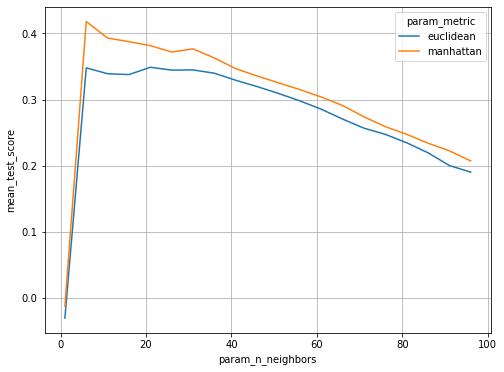

In [146]:
result = pd.DataFrame(model_kn.cv_results_)
temp = result.loc[:, ['param_n_neighbors','param_metric','mean_test_score']]
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_n_neighbors', y = 'mean_test_score', data = temp, hue = 'param_metric')
plt.grid()
plt.show()

In [57]:
params = {'n_neighbors': range(11,25), 'metric': ['euclidean', 'manhattan']}
model = KNeighborsRegressor()
model_kn1 = GridSearchCV(model, params, cv=10)

In [58]:
model_kn1.fit(x_train_s, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(11, 25)})

In [59]:
pred2 = model_kn1.predict(x_val_s)

In [60]:
model_kn1.best_params_

{'metric': 'manhattan', 'n_neighbors': 15}

In [61]:
model_kn1.best_score_

0.3752524739729019

In [62]:
printPerform(y_val, pred2)

R2 Score :  0.4208626240791241
RMSE :  2.035077877297738
MAE :  1.6277833333333334
MAPE :  0.28020462372502736
정확도 :  0.7197953762749727


### (3) Decision Tree

In [105]:
params = {'max_depth': range(2,11), 'min_samples_leaf': range(30,300,10)}
model = DecisionTreeRegressor()
model_de1 = GridSearchCV(model, params, cv=5)

In [95]:
model_de1.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(2, 11),
                         'min_samples_leaf': range(30, 300, 10)})

In [96]:
model_de1.best_params_

{'max_depth': 5, 'min_samples_leaf': 30}

In [97]:
model_de1.best_score_

0.4157478804119871

In [98]:
pred3 = model_de1.predict(x_val)

In [99]:
printPerform(y_val, pred3)

R2 Score :  0.6208584337244967
RMSE :  1.646610711196302
MAE :  1.4075084953037158
MAPE :  0.22757570256864765
정확도 :  0.7724242974313523


In [100]:
result = pd.DataFrame(model_de1.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002002,0.000633,0.001602,4.914222e-04,2,30,"{'max_depth': 2, 'min_samples_leaf': 30}",0.474852,0.369815,0.355746,0.422492,0.154222,0.355425,0.109042,9
1,0.001801,0.000400,0.001402,4.909341e-04,2,40,"{'max_depth': 2, 'min_samples_leaf': 40}",0.269992,0.369815,0.333818,0.490292,0.154222,0.323628,0.110986,18
2,0.001201,0.000401,0.001401,4.907586e-04,2,50,"{'max_depth': 2, 'min_samples_leaf': 50}",0.314477,0.369815,0.392387,0.104081,0.152702,0.266692,0.116750,27
3,0.001801,0.000400,0.001001,7.168434e-07,2,60,"{'max_depth': 2, 'min_samples_leaf': 60}",0.282523,0.263981,0.143787,0.219116,0.152702,0.212422,0.056382,29
4,0.001601,0.000490,0.001202,4.021883e-04,2,70,"{'max_depth': 2, 'min_samples_leaf': 70}",0.257746,0.263981,0.143787,0.219116,0.112787,0.199483,0.060923,47


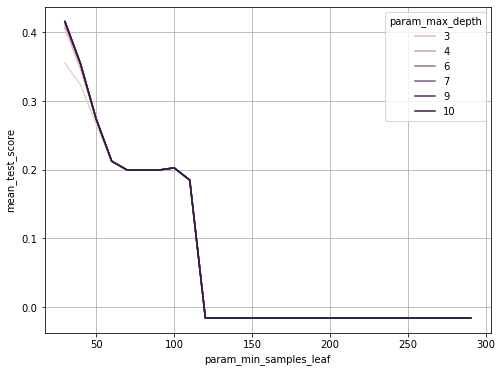

In [101]:
temp = result.loc[:, ['param_max_depth','param_min_samples_leaf', 'mean_test_score']]
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_min_samples_leaf', y = 'mean_test_score', data = temp, hue = 'param_max_depth')
plt.grid()
plt.show()

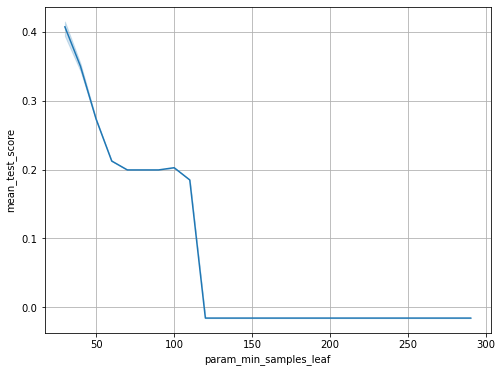

In [102]:
temp = result.loc[:, ['param_min_samples_leaf','mean_test_score']]
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_min_samples_leaf', y = 'mean_test_score', data = temp)
plt.grid()
plt.show()

In [104]:
params = {'max_depth': range(3,8), 'min_samples_leaf': range(60,110,2)}
model = DecisionTreeRegressor()
model_de2 = GridSearchCV(model, params, cv=10)

In [106]:
model_de2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(3, 8),
                         'min_samples_leaf': range(60, 110, 2)})

In [107]:
model_de2.best_params_

{'max_depth': 7, 'min_samples_leaf': 60}

In [108]:
model_de2.best_score_

0.21969602614890227

In [109]:
pred4 = model_de2.predict(x_val)

In [110]:
printPerform(y_val, pred4)

R2 Score :  0.3986923386580824
RMSE :  2.0736650348978585
MAE :  1.6854842469262294
MAPE :  0.2765250439081813
정확도 :  0.7234749560918188


### (4) Random Forest

In [149]:
params = {'max_depth' : range(2,12,3),'n_estimators' : range(81,250,4)}
model = RandomForestRegressor()
model_rf1 = GridSearchCV(model, params, cv=6)

In [150]:
model_rf1.fit(x_train, y_train)

GridSearchCV(cv=6, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(2, 12, 3),
                         'n_estimators': range(81, 250, 4)})

In [115]:
pred5 = model_rf1.predict(x_val)

In [116]:
model_rf1.best_params_

{'n_estimators': 99}

In [117]:
model_rf1.best_score_

0.7431731505656014

In [121]:
printPerform(y_val, pred5)

R2 Score :  0.7548339470408991
RMSE :  1.3240988361723347
MAE :  1.0657929292929296
MAPE :  0.17475497389205855
정확도 :  0.8252450261079415


In [118]:
result = pd.DataFrame(model_rf1.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.147069,0.009392,0.009012,0.001632,81,{'n_estimators': 81},0.828325,0.775817,0.743065,0.656202,0.758991,0.646599,0.734833,0.064601,72
1,0.166937,0.018092,0.009774,0.001575,83,{'n_estimators': 83},0.841524,0.760437,0.735358,0.678590,0.774876,0.646701,0.739581,0.063819,23
2,0.181230,0.010661,0.009936,0.001360,85,{'n_estimators': 85},0.829653,0.755181,0.742196,0.672950,0.770668,0.616497,0.731191,0.068916,84
3,0.158920,0.009970,0.009288,0.001029,87,{'n_estimators': 87},0.831020,0.761196,0.737468,0.656500,0.765464,0.659417,0.735178,0.061529,66
4,0.156299,0.006321,0.009492,0.001487,89,{'n_estimators': 89},0.839590,0.749678,0.735199,0.686293,0.764799,0.633814,0.734895,0.064101,69


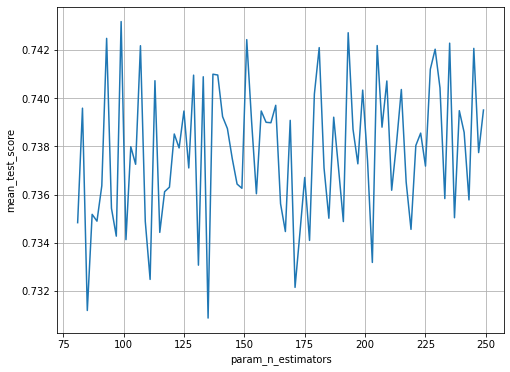

In [119]:
temp = result.loc[:, ['param_n_estimators','mean_test_score']]
plt.figure(figsize = (8,6))
sns.lineplot(x = 'param_n_estimators', y = 'mean_test_score', data = temp)
plt.grid()
plt.show()

In [122]:
params = {'n_estimators' : range(120,165)}
model = RandomForestRegressor()
model_rf2 = GridSearchCV(model, params, cv=10)

In [123]:
model_rf2.fit(x_train, y_train)
pred6 = model_rf2.predict(x_val)

In [124]:
model_rf2.best_params_

{'n_estimators': 151}

In [125]:
model_rf2.best_score_

0.7449177042730222

In [126]:
printPerform(y_val, pred6)

R2 Score :  0.7559016527873879
RMSE :  1.3212124444613587
MAE :  1.0635314569536423
MAPE :  0.1754340261817294
정확도 :  0.8245659738182706


### (5) XGB